# Data Analysis and Prediction

#Table of Contents
* [Data Analysis and Prediction](#Data-Analysis-and-Prediction)
	* [1. Introduction](#1.-Introduction)

##1. Introduction 

In [1]:
%matplotlib inline
import numpy as np
import scipy as sp
from itertools import product
import json 
import csv
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")

In [26]:
df=pd.read_csv("dftouse.csv")

In [27]:
del df['Unnamed: 0']
del df['ReserveMet']
del df['ListingStatus']
df = df[pd.isnull(df.HitCount) == False]

##3.

In [28]:
dftouse = df.copy()
dftouse.head()

,country,itemId,paymentMethod,postalCode,sellingStatus,topRatedListing,AutoPay,AvailableForPickupDropOff,BestOfferEnabled,BidCount,BuyItNowPrice,FinalPrice,GlobalShipping,HandlingTime,HitCount,ListingType,Location,MinimumToBid,ProductID,Quantity,QuantityThreshold,ShipToLocations,Title,UserID,FeedbackScore,PositiveFeedbackPercent,SellerBusinessType,NewUser,nPhotos,nPaymentMethods,nShippingCountries,conditionId,bestOfferEnabled,buyItNowAvailable,expeditedShipping,shippingType,oneDayShippingAvailable,RatingsPresent,AverageRating,NegFeedback30Day,NegFeedback365Day,PosFeedback30Day,PosFeedback365Day,auctionLength
0,0,131642735687,0,10590,0,False,False,0,False,41,NaN,202.09,False,2,190,0,"South Salem, New York",204.59,NaN,1,0,US,iPhone 5s-32gb-Space Gray-unlocked,jdwein1980,19,100.0,2,False,3,1,1,5,False,False,True,2,False,False,NaN,0,0,5,5,168
1,0,262126933108,0,35004,0,False,False,0,False,4,NaN,260.00,False,3,32,0,"Moody, Alabama",265.00,NaN,1,0,US,apple iphone 5s 32gb,forwhlrcr1965,565,100.0,1,False,2,1,1,5,False,False,True,0,False,False,NaN,0,0,3,32,120
2,0,252155964081,0,98104,0,False,False,0,False,3,NaN,152.50,False,2,168,0,"Seattle, Washington",155.00,168534287,1,0,Worldwide,Apple iPhone 5s - 32GB SPACE GRAY AT&T,15-alice,15,94.1,1,False,2,1,1,5,False,False,False,1,False,False,NaN,0,1,2,17,120
3,0,252163774777,0,98104,0,False,False,0,False,1,NaN,99.00,False,2,143,0,"Seattle, Washington",100.00,168553370,1,0,US,Apple iPhone 5s - 32GB - Silver (Verizon) Smar...,15-alice,15,94.1,1,False,7,1,1,9,False,False,True,0,False,False,NaN,0,1,2,17,120
4,0,252171170160,0,98104,0,False,True,0,False,5,NaN,96.00,False,2,357,0,"Seattle, Washington",97.00,168534287,1,0,US,Apple iPhone 5s - 32GB SPACE GRAY AT&T,15-alice,15,94.1,1,False,2,1,1,5,False,False,False,1,False,False,NaN,0,1,2,17,120


In [29]:
ZERO_IMPORTANT_VARIABLES = ['BidCount', 'HitCount', 'nPhotos', 'FeedbackScore', 'PositiveFeedbackPercent',
                           'NegFeedback30Day', 'NegFeedback365Day', 'PosFeedback30Day', 'PosFeedback365Day']
STANDARDIZABLE = ZERO_IMPORTANT_VARIABLES + ['FinalPrice','auctionLength', 'HandlingTime', 'FeedbackScore', 
                  'PositiveFeedbackPercent', 'Quantity', 'nPaymentMethods', 'nShippingCountries', 'auctionLength']
INDICATORS = []

In [30]:
for v in df.columns:
    if v != 'sellingStatus':
        l=df[v].unique()
        if len(l) <= 10:
            if v not in STANDARDIZABLE:
                dftouse.rename(columns={v:'i_'+v}, inplace=True)
                INDICATORS.append('i_'+v)
            else:
                dftouse['i_'+v]=(dftouse[v] > 0.0)*1
                INDICATORS.append('i_'+v)
            print v, l

for v in ZERO_IMPORTANT_VARIABLES:
    dftouse['i_'+v]=(dftouse[v] > 0.0)*1
    INDICATORS.append('i_'+v)
    print v
    
#INDICATORS.remove('i_sellingStatus')
print INDICATORS


country [0 1]
paymentMethod [0 1]
topRatedListing [False True]
AutoPay [False True]
AvailableForPickupDropOff [0 1]
BestOfferEnabled [False True]
GlobalShipping [False True]
HandlingTime [ 2.  3.  1.  0.]
ListingType [0 1]
QuantityThreshold [  0.  10.]
SellerBusinessType [2 1 0]
NewUser [False True]
nPaymentMethods [1 2 4 3]
conditionId [5 9 0 1 3 4]
bestOfferEnabled [False True]
buyItNowAvailable [False True]
expeditedShipping [True False]
shippingType [ 2.  0.  1.  3.  4.  8.]
oneDayShippingAvailable [False True]
RatingsPresent [False True]
BidCount
HitCount
nPhotos
FeedbackScore
PositiveFeedbackPercent
NegFeedback30Day
NegFeedback365Day
PosFeedback30Day
PosFeedback365Day
['i_country', 'i_paymentMethod', 'i_topRatedListing', 'i_AutoPay', 'i_AvailableForPickupDropOff', 'i_BestOfferEnabled', 'i_GlobalShipping', 'i_HandlingTime', 'i_ListingType', 'i_QuantityThreshold', 'i_SellerBusinessType', 'i_NewUser', 'i_nPaymentMethods', 'i_conditionId', 'i_bestOfferEnabled', 'i_buyItNowAvailable',

In [31]:
from sklearn.cross_validation import train_test_split
itrain, itest = train_test_split(xrange(dftouse.shape[0]), train_size=0.7)

In [32]:
mask=np.ones(dftouse.shape[0], dtype='int')
mask[itrain]=1
mask[itest]=0
mask = (mask==1)

In [33]:
mask

array([False,  True,  True, ...,  True,  True,  True], dtype=bool)

In [34]:
mask.shape, mask.sum()

((9267,), 6486)

In [35]:
from sklearn import preprocessing

#we make our training and testing sets w/ standarized
scaler = preprocessing.StandardScaler().fit(dftouse[mask][STANDARDIZABLE])
dftouse.loc[mask, STANDARDIZABLE] = scaler.transform(dftouse[mask][STANDARDIZABLE]) 
dftouse.loc[~mask,STANDARDIZABLE] = scaler.transform(dftouse[~mask][STANDARDIZABLE])


dftouse[mask].head()

,i_country,itemId,i_paymentMethod,postalCode,sellingStatus,i_topRatedListing,i_AutoPay,i_AvailableForPickupDropOff,i_BestOfferEnabled,BidCount,BuyItNowPrice,FinalPrice,i_GlobalShipping,HandlingTime,HitCount,i_ListingType,Location,MinimumToBid,ProductID,Quantity,i_QuantityThreshold,ShipToLocations,Title,UserID,FeedbackScore,PositiveFeedbackPercent,i_SellerBusinessType,i_NewUser,nPhotos,nPaymentMethods,nShippingCountries,i_conditionId,i_bestOfferEnabled,i_buyItNowAvailable,i_expeditedShipping,i_shippingType,i_oneDayShippingAvailable,i_RatingsPresent,AverageRating,NegFeedback30Day,NegFeedback365Day,PosFeedback30Day,PosFeedback365Day,auctionLength,i_HandlingTime,i_nPaymentMethods,i_BidCount,i_HitCount,i_nPhotos,i_FeedbackScore,i_PositiveFeedbackPercent,i_NegFeedback30Day,i_NegFeedback365Day,i_PosFeedback30Day,i_PosFeedback365Day
1,0,262126933108,0,35004,0,False,False,0,False,-0.229157,NaN,0.022210,False,1.778492,-0.055768,0,"Moody, Alabama",265,NaN,-0.046353,0,US,apple iphone 5s 32gb,forwhlrcr1965,-0.202410,0.308428,1,False,-1.132567,-0.073725,-0.832561,5,False,False,True,0,False,False,NaN,-0.156143,-0.242223,-0.274962,-0.301301,-0.060280,1,1,1,1,1,1,1,0,0,1,1
2,0,252155964081,0,98104,0,False,False,0,False,-0.308019,NaN,-0.632761,False,0.417395,-0.040397,0,"Seattle, Washington",155,168534287,-0.046353,0,Worldwide,Apple iPhone 5s - 32GB SPACE GRAY AT&T,15-alice,-0.221537,0.084648,1,False,-1.132567,-0.073725,-0.832561,5,False,False,False,1,False,False,NaN,-0.156143,-0.205812,-0.279091,-0.306365,-0.060280,1,1,1,1,1,1,1,0,1,1,1
3,0,252163774777,0,98104,0,False,False,0,False,-0.465744,NaN,-0.958724,False,0.417395,-0.043223,0,"Seattle, Washington",100,168553370,-0.046353,0,US,Apple iPhone 5s - 32GB - Silver (Verizon) Smar...,15-alice,-0.221537,0.084648,1,False,0.497738,-0.073725,-0.832561,9,False,False,True,0,False,False,NaN,-0.156143,-0.205812,-0.279091,-0.306365,-0.060280,1,1,1,1,1,1,1,0,1,1,1
4,0,252171170160,0,98104,0,False,True,0,False,-0.150295,NaN,-0.977002,False,0.417395,-0.019035,0,"Seattle, Washington",97,168534287,-0.046353,0,US,Apple iPhone 5s - 32GB SPACE GRAY AT&T,15-alice,-0.221537,0.084648,1,False,-1.132567,-0.073725,-0.832561,5,False,False,False,1,False,False,NaN,-0.156143,-0.205812,-0.279091,-0.306365,-0.060280,1,1,1,1,1,1,1,0,1,1,1
7,0,171993101164,0,27045,0,False,True,0,False,-0.544606,NaN,-0.008254,True,0.417395,-0.057351,1,"Rural Hall, North Carolina",NaN,168553370,-0.046353,0,"[US, CA, GB, DK, RO, SK, BG, CZ, FI, HU, LV, L...",Apple iPhone 5s 32GB CUSTOM BlacK/Silver Veriz...,clint22468,-0.194168,0.289464,1,False,2.128043,-0.073725,1.275816,5,False,False,False,3,False,True,4.9275,-0.156143,-0.205812,-0.118057,-0.241212,-0.324088,1,1,0,1,1,1,1,0,1,1,1


In [37]:
lcols=list(dftouse.columns)
lcols.remove(u'sellingStatus')
print lcols
print len(lcols)

['i_country', 'itemId', 'i_paymentMethod', 'postalCode', 'i_topRatedListing', 'i_AutoPay', 'i_AvailableForPickupDropOff', 'i_BestOfferEnabled', 'BidCount', 'BuyItNowPrice', 'FinalPrice', 'i_GlobalShipping', 'HandlingTime', 'HitCount', 'i_ListingType', 'Location', 'MinimumToBid', 'ProductID', 'Quantity', 'i_QuantityThreshold', 'ShipToLocations', 'Title', 'UserID', 'FeedbackScore', 'PositiveFeedbackPercent', 'i_SellerBusinessType', 'i_NewUser', 'nPhotos', 'nPaymentMethods', 'nShippingCountries', 'i_conditionId', 'i_bestOfferEnabled', 'i_buyItNowAvailable', 'i_expeditedShipping', 'i_shippingType', 'i_oneDayShippingAvailable', 'i_RatingsPresent', 'AverageRating', 'NegFeedback30Day', 'NegFeedback365Day', 'PosFeedback30Day', 'PosFeedback365Day', 'auctionLength', 'i_HandlingTime', 'i_nPaymentMethods', 'i_BidCount', 'i_HitCount', 'i_nPhotos', 'i_FeedbackScore', 'i_PositiveFeedbackPercent', 'i_NegFeedback30Day', 'i_NegFeedback365Day', 'i_PosFeedback30Day', 'i_PosFeedback365Day']
54


In [38]:
#type(dftouse['i_ShipToLocations'][0])

In [39]:
ccols=[]
for c in lcols:
    if c not in INDICATORS:
        ccols.append(c)
print len(ccols), len(INDICATORS)
print ccols

ccols.remove('itemId')
ccols.remove('postalCode')
#ccols.remove('sellingStatus')
ccols.remove('Location')
ccols.remove('ProductID')
ccols.remove('ShipToLocations')
ccols.remove('Title')
ccols.remove('UserID')


25 29
['itemId', 'postalCode', 'BidCount', 'BuyItNowPrice', 'FinalPrice', 'HandlingTime', 'HitCount', 'Location', 'MinimumToBid', 'ProductID', 'Quantity', 'ShipToLocations', 'Title', 'UserID', 'FeedbackScore', 'PositiveFeedbackPercent', 'nPhotos', 'nPaymentMethods', 'nShippingCountries', 'AverageRating', 'NegFeedback30Day', 'NegFeedback365Day', 'PosFeedback30Day', 'PosFeedback365Day', 'auctionLength']


In [40]:
dftouse.head()

,i_country,itemId,i_paymentMethod,postalCode,sellingStatus,i_topRatedListing,i_AutoPay,i_AvailableForPickupDropOff,i_BestOfferEnabled,BidCount,BuyItNowPrice,FinalPrice,i_GlobalShipping,HandlingTime,HitCount,i_ListingType,Location,MinimumToBid,ProductID,Quantity,i_QuantityThreshold,ShipToLocations,Title,UserID,FeedbackScore,PositiveFeedbackPercent,i_SellerBusinessType,i_NewUser,nPhotos,nPaymentMethods,nShippingCountries,i_conditionId,i_bestOfferEnabled,i_buyItNowAvailable,i_expeditedShipping,i_shippingType,i_oneDayShippingAvailable,i_RatingsPresent,AverageRating,NegFeedback30Day,NegFeedback365Day,PosFeedback30Day,PosFeedback365Day,auctionLength,i_HandlingTime,i_nPaymentMethods,i_BidCount,i_HitCount,i_nPhotos,i_FeedbackScore,i_PositiveFeedbackPercent,i_NegFeedback30Day,i_NegFeedback365Day,i_PosFeedback30Day,i_PosFeedback365Day
0,0,131642735687,0,10590,0,False,False,0,False,2.688741,NaN,-0.330622,False,0.417395,-0.037910,0,"South Salem, New York",204.59,NaN,-0.046353,0,US,iPhone 5s-32gb-Space Gray-unlocked,jdwein1980,-0.221397,0.308428,2,False,-0.806506,-0.073725,-0.832561,5,False,False,True,2,False,False,NaN,-0.156143,-0.242223,-0.266704,-0.310416,0.045243,1,1,1,1,1,1,1,0,0,1,1
1,0,262126933108,0,35004,0,False,False,0,False,-0.229157,NaN,0.022210,False,1.778492,-0.055768,0,"Moody, Alabama",265.00,NaN,-0.046353,0,US,apple iphone 5s 32gb,forwhlrcr1965,-0.202410,0.308428,1,False,-1.132567,-0.073725,-0.832561,5,False,False,True,0,False,False,NaN,-0.156143,-0.242223,-0.274962,-0.301301,-0.060280,1,1,1,1,1,1,1,0,0,1,1
2,0,252155964081,0,98104,0,False,False,0,False,-0.308019,NaN,-0.632761,False,0.417395,-0.040397,0,"Seattle, Washington",155.00,168534287,-0.046353,0,Worldwide,Apple iPhone 5s - 32GB SPACE GRAY AT&T,15-alice,-0.221537,0.084648,1,False,-1.132567,-0.073725,-0.832561,5,False,False,False,1,False,False,NaN,-0.156143,-0.205812,-0.279091,-0.306365,-0.060280,1,1,1,1,1,1,1,0,1,1,1
3,0,252163774777,0,98104,0,False,False,0,False,-0.465744,NaN,-0.958724,False,0.417395,-0.043223,0,"Seattle, Washington",100.00,168553370,-0.046353,0,US,Apple iPhone 5s - 32GB - Silver (Verizon) Smar...,15-alice,-0.221537,0.084648,1,False,0.497738,-0.073725,-0.832561,9,False,False,True,0,False,False,NaN,-0.156143,-0.205812,-0.279091,-0.306365,-0.060280,1,1,1,1,1,1,1,0,1,1,1
4,0,252171170160,0,98104,0,False,True,0,False,-0.150295,NaN,-0.977002,False,0.417395,-0.019035,0,"Seattle, Washington",97.00,168534287,-0.046353,0,US,Apple iPhone 5s - 32GB SPACE GRAY AT&T,15-alice,-0.221537,0.084648,1,False,-1.132567,-0.073725,-0.832561,5,False,False,False,1,False,False,NaN,-0.156143,-0.205812,-0.279091,-0.306365,-0.060280,1,1,1,1,1,1,1,0,1,1,1


BidCount
BuyItNowPrice
FinalPrice
HandlingTime
HitCount
MinimumToBid
Quantity
FeedbackScore
PositiveFeedbackPercent
nPhotos
nPaymentMethods
nShippingCountries
AverageRating
NegFeedback30Day
NegFeedback365Day
PosFeedback30Day
PosFeedback365Day
auctionLength


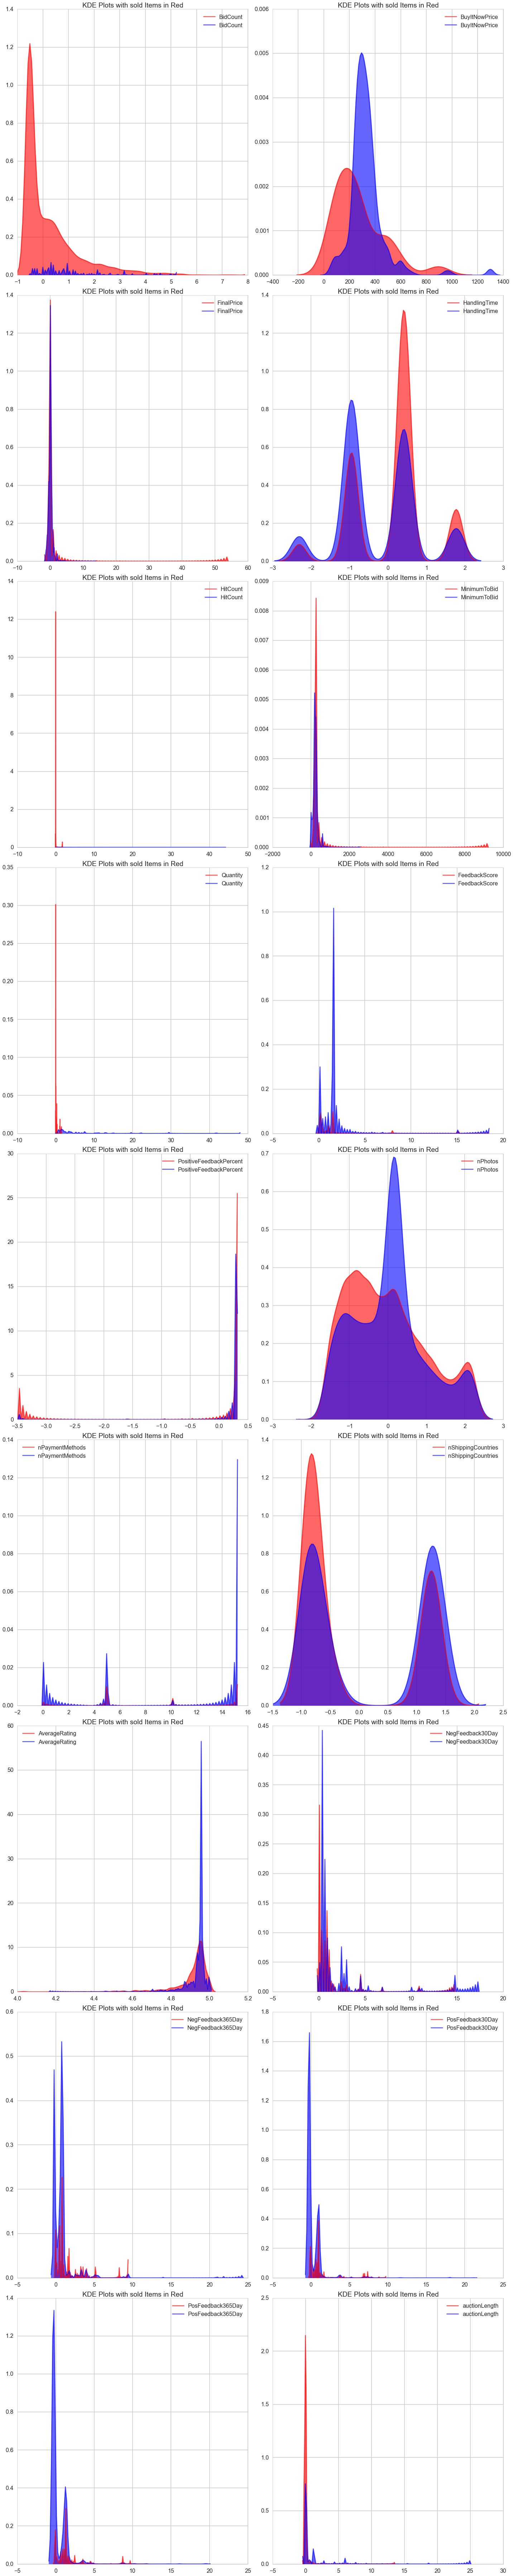

In [41]:
fig, axes = plt.subplots(nrows=9, ncols=2, sharex=False, sharey=False, figsize=(20, 100), 
                         tight_layout=True)
for ax, ccol in zip(axes.ravel(), ccols):
    
    #plot mean values per year based on response to mailing
    df_col = dftouse[ccol]
    print ccol
    sns.kdeplot(df_col[dftouse['sellingStatus'] == 0], color='r', alpha=.6, ax=ax, shade=True, legend=True)
    sns.kdeplot(df_col[dftouse['sellingStatus'] == 1], color='b', alpha=.6, ax=ax, shade=True)
    ax.set_title("KDE Plots with sold Items in Red")

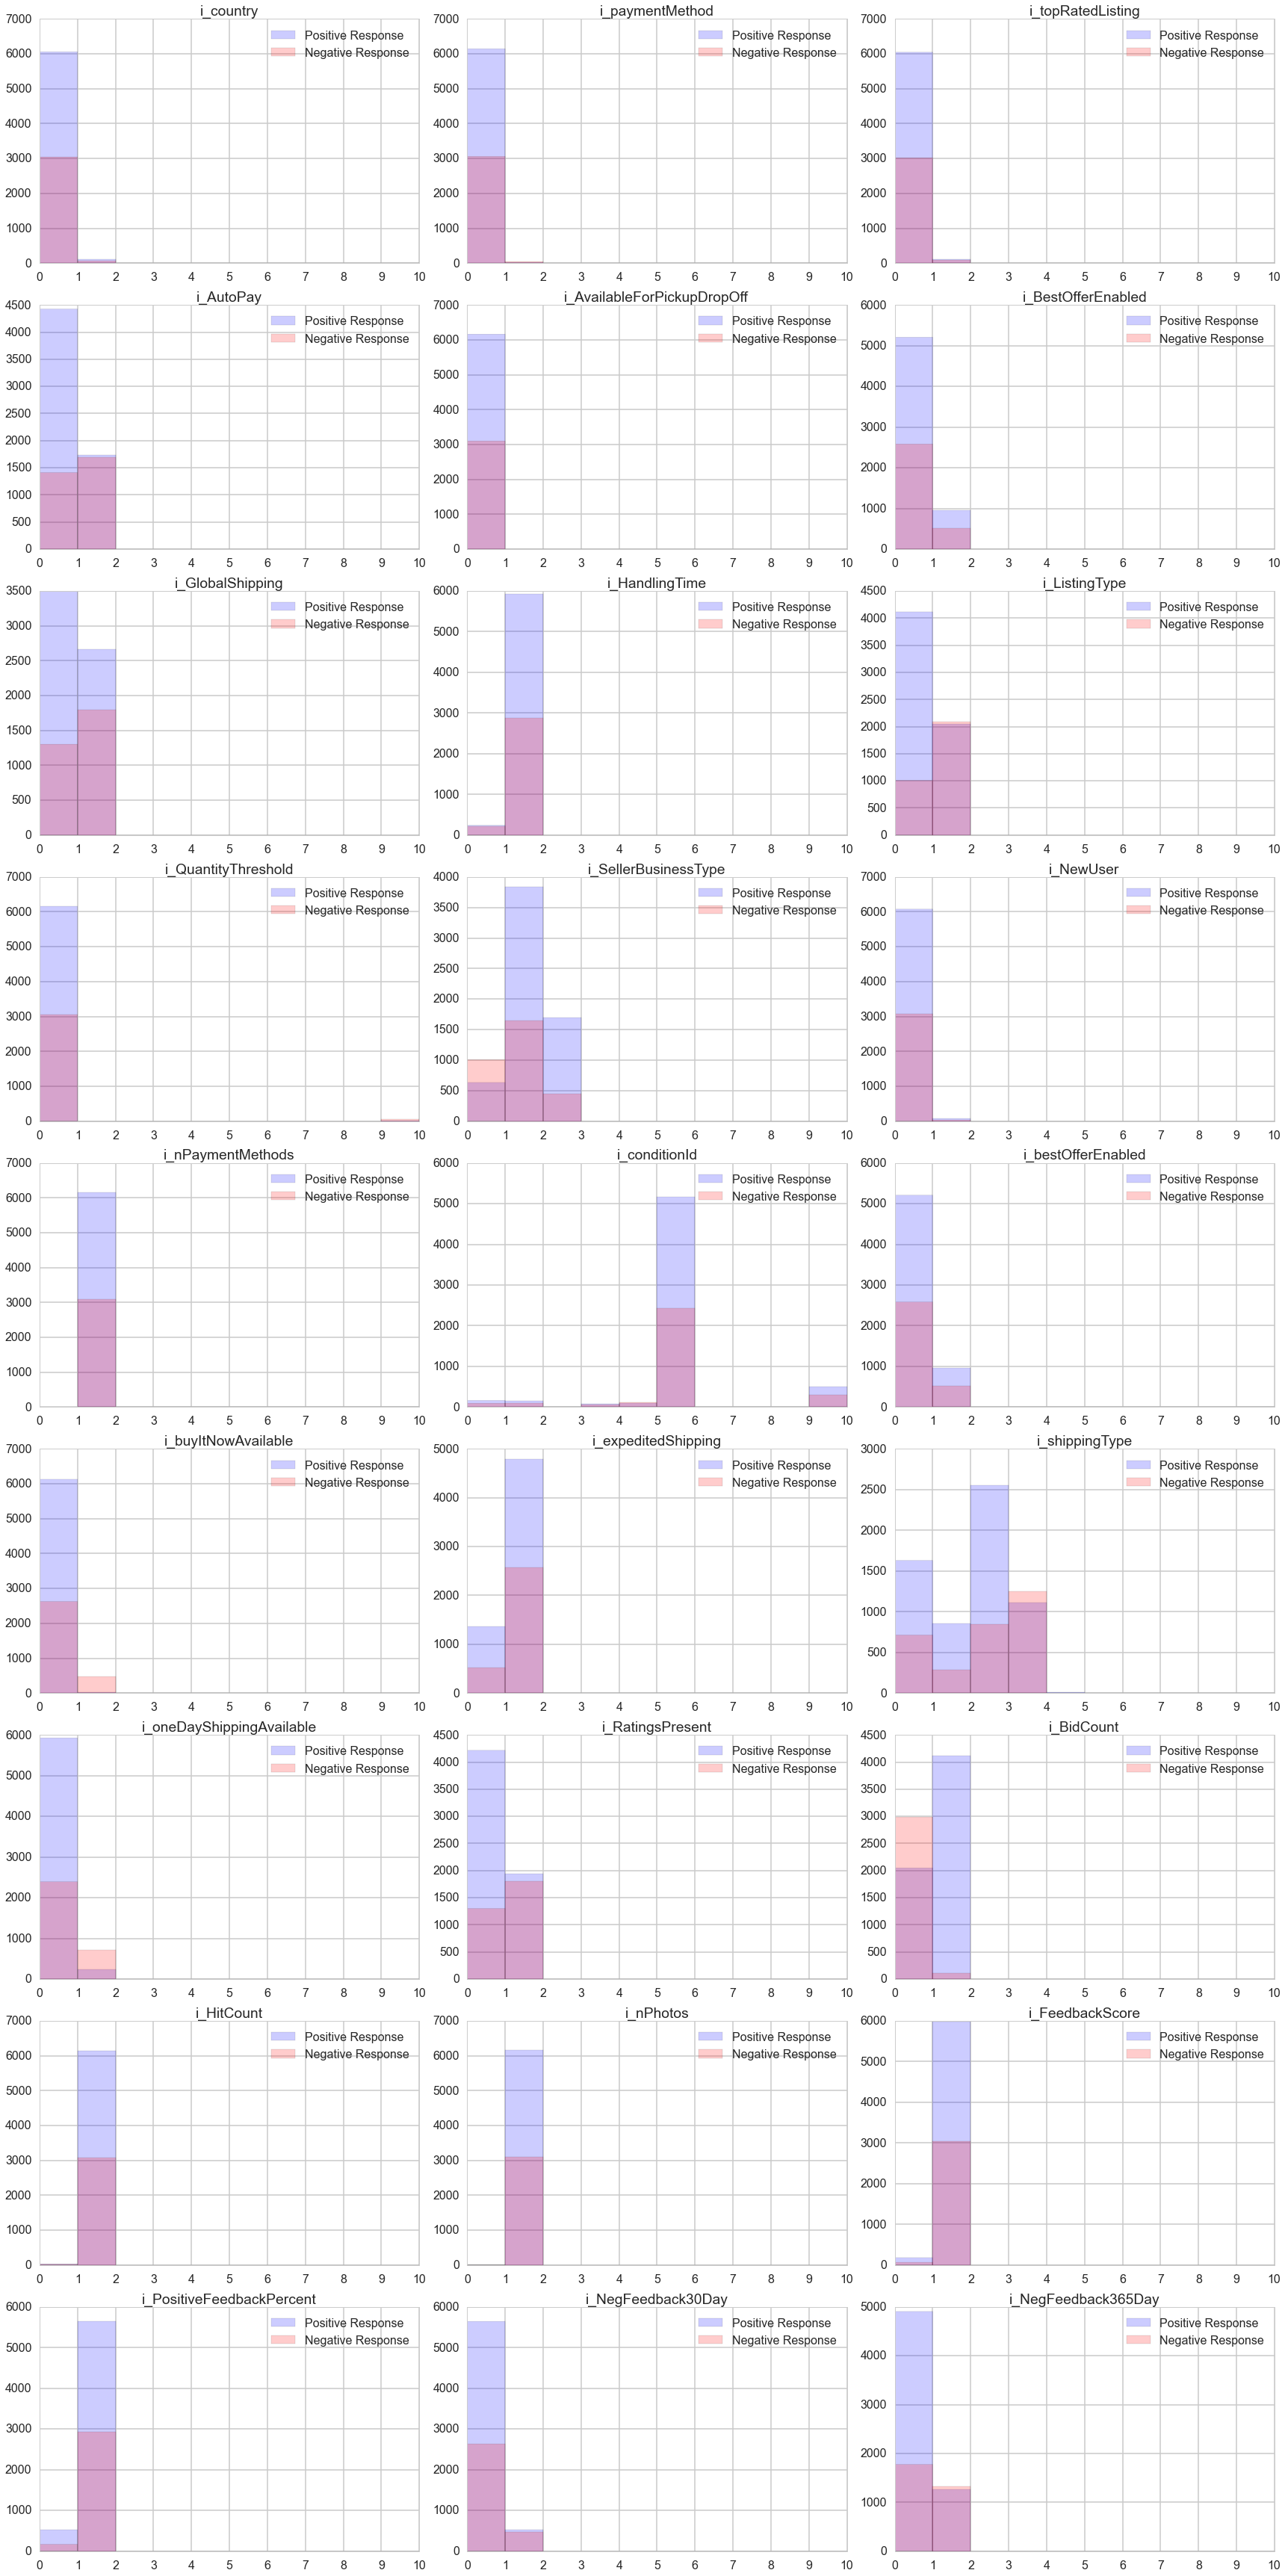

In [49]:
#setup similar layout
fig, axes = plt.subplots(nrows=9, ncols=3, figsize = (24,48),
                         tight_layout=True)

positives = dftouse[dftouse['sellingStatus'] == 0]
negatives = dftouse[dftouse['sellingStatus'] == 1]

for ax, data in zip(axes.ravel(), INDICATORS):
    ax.hist(positives[data].values, range = [0,10], bins = 10, color = 'b', alpha = 0.2, label = 'Positive Response')
    ax.hist(negatives[data].values, range = [0,10], bins = 10, color = 'r', alpha = 0.2, label = 'Negative Response')
    ax.set_xticks(range(0,11))
    ax.legend()
    ax.set_title(data)
    

In [56]:
dftouse['Title'].unique()

array(['iPhone 5s-32gb-Space Gray-unlocked', 'apple iphone 5s 32gb',
       'Apple iPhone 5s - 32GB SPACE GRAY AT&T', ...,
       'Apple iPhone 5s - 32GB - Space Gray(Factory Unlocked) - CLEAN IMEI - READY TO GO',
       'FACTORY UNLOCKED Apple iPhone 5S 32GB GOLD Global GSM LTE Unlocked Phone 5S',
       'Apple iPhone 5s 32GB (Unlocked)'], dtype=object)